In [3]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in c:\users\jaysu\anaconda3\lib\site-packages (0.0)


In [4]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_csv("../data/exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()


# Select your features (columns)

In [3]:
# Set features. This will also be used as your x values.
# these features seem interesting according to the documentation ['koi_period', 'koi_impact', 'koi_duration', koi_prad', 'koi_teq', 'koi_slogg', 'koi_srad', ]
selected_features = df[['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_model_snr', 'koi_duration_err2']]
selected_features.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_model_snr,koi_duration_err2
0,0,0,0,0,25.8,-0.11600
1,0,1,0,0,76.3,-0.03410
2,0,1,0,0,505.6,-0.00537
3,0,0,0,0,40.9,-0.04200
4,0,0,0,0,40.2,-0.06730


# Create a Train Test Split

Use `koi_disposition` for the y values

In [4]:
# pull out the output labels column or y values
labels = df['koi_disposition']

In [5]:
# Split the data in training and test groups
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, train_size=.8, random_state=3 )

In [6]:
# inspect the new dataframe to see it's shape
X_train

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_model_snr,koi_duration_err2
2471,0,0,0,0,31.9,-0.08280
1965,0,0,0,0,71.6,-0.07130
6013,1,0,0,0,12.0,-0.91100
9,0,0,0,0,1741.5,-0.00653
2665,0,0,0,0,45.5,-0.05530
...,...,...,...,...,...,...
968,1,0,0,0,78.6,-0.55900
1667,0,0,0,0,17.5,-0.15500
3321,0,0,0,0,14.1,-0.13000
1688,0,0,0,0,23.0,-0.06660


# Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

[0.         0.         0.         0.         0.0035332  0.99590099]


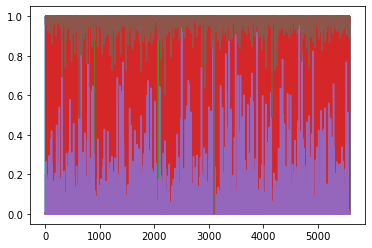

In [7]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled

# inspect the scaled data to see how the feature values have been scaled
print(X_train_scaled[0])

# Plot the scaled data
import matplotlib.pyplot as plt 
plt.plot(X_train_scaled)

# Train the Model



In [8]:
# Random Forest Classifier model for training
# Hypertuning results: {'bootstrap': True, 'max_depth': 40, 'min_samples_split': 8, 'n_estimators': 200}
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=10, bootstrap= True, max_depth= 10, min_samples_split= 8)
# clf = clf.fit(X_train_scaled, y_train)

# print(f"Training Data Score: {clf.score(X_train_scaled, y_train)}")
# print(f"Testing Data Score: {clf.score(X_test_scaled, y_test)}")

In [9]:
# need to pick the setting anad rsearch

k: 1, Train/Test Score: 0.999/0.818
k: 3, Train/Test Score: 0.914/0.857
k: 5, Train/Test Score: 0.897/0.874
k: 7, Train/Test Score: 0.895/0.871
k: 9, Train/Test Score: 0.891/0.876
k: 11, Train/Test Score: 0.891/0.874
k: 13, Train/Test Score: 0.887/0.874
k: 15, Train/Test Score: 0.888/0.875
k: 17, Train/Test Score: 0.888/0.877
k: 19, Train/Test Score: 0.888/0.876


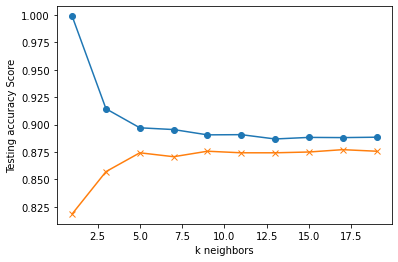

In [10]:
from sklearn.neighbors import KNeighborsClassifier
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [12]:
# Note that k: 13 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
print('k=5 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=5 Test Acc: 0.874


# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [14]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [17]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid={'leaf_size': [20, 30, 40], 'n_neighbors' : [3, 5, 7, 9],
'p' : [1, 2]}
grid = GridSearchCV(knn, param_grid, verbose=3)

# To get list of parameters you can tune
knn.get_params().keys()
# grid.fit(X_train_scaled, y_train)

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [18]:
# Train the model with GridSearch
grid.fit(X_train_scaled, y_train)

0, n_neighbors=3, p=2, score=0.865, total=   0.1s
[CV] leaf_size=40, n_neighbors=3, p=3 ................................
[CV] .... leaf_size=40, n_neighbors=3, p=3, score=0.853, total=   0.3s
[CV] leaf_size=40, n_neighbors=3, p=3 ................................
[CV] .... leaf_size=40, n_neighbors=3, p=3, score=0.857, total=   0.3s
[CV] leaf_size=40, n_neighbors=3, p=3 ................................
[CV] .... leaf_size=40, n_neighbors=3, p=3, score=0.870, total=   0.3s
[CV] leaf_size=40, n_neighbors=3, p=3 ................................
[CV] .... leaf_size=40, n_neighbors=3, p=3, score=0.843, total=   0.4s
[CV] leaf_size=40, n_neighbors=3, p=3 ................................
[CV] .... leaf_size=40, n_neighbors=3, p=3, score=0.867, total=   0.3s
[CV] leaf_size=40, n_neighbors=3, p=4 ................................
[CV] .... leaf_size=40, n_neighbors=3, p=4, score=0.853, total=   0.3s
[CV] leaf_size=40, n_neighbors=3, p=4 ................................
[CV] .... leaf_size=40, n_n

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [10, 20, 30, 40],
                         'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'p': [1, 2, 3, 4, 5]},
             verbose=3)

In [19]:
print(grid.best_params_)
print(grid.best_score_)

{'leaf_size': 10, 'n_neighbors': 11, 'p': 5}
0.8776853215159843


# Save the Model

In [20]:
import joblib
filename = 'model_2_randomforest_extratreeclassifer.h5'
joblib.dump(clf, filename)

['model_2_randomforest_extratreeclassifer.h5']